In [2]:
%load_ext autoreload
%autoreload 2

import scanpy
import numpy as np
import utils
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
dspath=['data/Koh/koh.h5ad','data/Kumar/kumar.h5ad', 'data/simkumar/simkumar4easy.h5ad','data/simkumar/simkumar4hard.h5ad','data/simkumar/simkumar8hard.h5ad','data/Trapnell/trapnell.h5ad','data/zheng/sce_full_Zhengmix4eq.h5ad','data/zheng/sce_full_Zhengmix4uneq.h5ad','data/zheng/sce_full_Zhengmix8eq.h5ad']
dsname=['Koh','Kumar','simkumar4easy','simkumar4hard','simkumar8hard','Trapnell','Zheng4eq','Zheng4uneq','Zheng8eq']
removals = np.arange(0.01, 0.26, 0.01)
def initiate(**kwargs):


    fix_ch= int(kwargs.get('fix_ch', -1))


    if(fix_ch==-1):
        fix_ch=int(input([(i,dsname[i]) for i in range(9)]))


    sce_data = scanpy.read_h5ad(dspath[fix_ch])
    data, cs, labels = utils.parse_h5ad(sce_data, 'phenoid')
    data= np.log1p(data)

    return data, cs, labels

In [12]:
def process(data,cs,labels,dimension,fix_ch, C=None):


    if C is None:
        C, avg_inter, avg_intra = utils.get_compressibility(data, cs, dimension, True)
    else: 
        avg_inter, avg_intra = utils.get_average_compression(C, cs, len(cs))
    print('Avg intercluster compressibility', avg_inter)
    print('Avg intracluster compressibility', avg_intra)

    var = utils.get_variances(C)
    var_combined = [(var[i], labels[i]) for i in range(len(var))]
    var_combined.sort(key=lambda x: x[0])

    # Plot variance of compressibility
    plt.figure(figsize=(9,9))
    plt.title('Variance of compressibility for '+dsname[fix_ch])
    ordered_var = [var_combined[i][0] for i in range(len(var_combined))]
    colors = [var_combined[i][1] for i in range(len(var_combined))]
    plt.scatter(np.arange(len(var)), ordered_var, c=colors, s=5)
    plt.show()

    # Plot compressibility
    cgraph = utils.compression_grouping(C, cs)[::-1]
    step_size = 100
    index = list(range(0, len(cgraph), step_size))

    plt.figure(figsize=(9,9))
    plt.scatter(index, cgraph[index, 0], c=cgraph[index, 1], s=5)
    plt.yscale('log')
    plt.title('Compressibility curve for '+dsname[fix_ch])
    plt.show()

    diff = []
    ARI, NMI = None, None
    for removal in tqdm(removals):
        ari, nmi, ari_rem, nmi_rem = utils.kmeans_removal(data, cs, labels, dimension, None, removal, True, C, ARI, NMI)
        ARI = ari
        NMI = nmi 
        diff.append((ari_rem, nmi_rem))
    
    print("ARI without removal:", ARI)
    print("NMI without removal:", NMI)

    plt.figure(figsize=(9,9))
    plt.plot(removals, [x[1] - NMI for x in diff])
    plt.xlabel('Removal rate')
    plt.ylabel('NMI improvement (removal - no removal)')
    plt.title('NMI improvement for '+dsname[fix_ch])

    plt.figure(figsize=(9,9))
    plt.plot(removals, [x[0] - ARI for x in diff])
    plt.xlabel('Removal rate')
    plt.ylabel('ARI improvement (removal - no removal)')
    plt.title('ARI improvement '+dsname[fix_ch])

In [6]:
for path in dspath: 
    sce_data = scanpy.read_h5ad(path)
    data, cs, labels = utils.parse_h5ad(sce_data, 'phenoid')
    data= np.log1p(data)

    C, _, __, = utils.get_compressibility(data, cs, len(cs), True)

    np.save(path[:-5]+'_C_cs.npy', C)

In [7]:
for path in dspath: 
    sce_data = scanpy.read_h5ad(path)
    data, cs, labels = utils.parse_h5ad(sce_data, 'phenoid')
    data= np.log1p(data)

    C, _, __, = utils.get_compressibility(data, cs, 25, True)

    np.save(path[:-5]+'_C_25.npy', C)

Avg intercluster compressibility [2.38914212 2.49742085 2.64986061 2.47706495 2.48535802 2.895674
 2.3222805  2.59974459 2.00156236]
Avg intracluster compressibility [7.319468   9.16643103 6.39160073 5.76661791 6.13732487 8.02897146
 6.35076181 6.99793325 7.07448309]


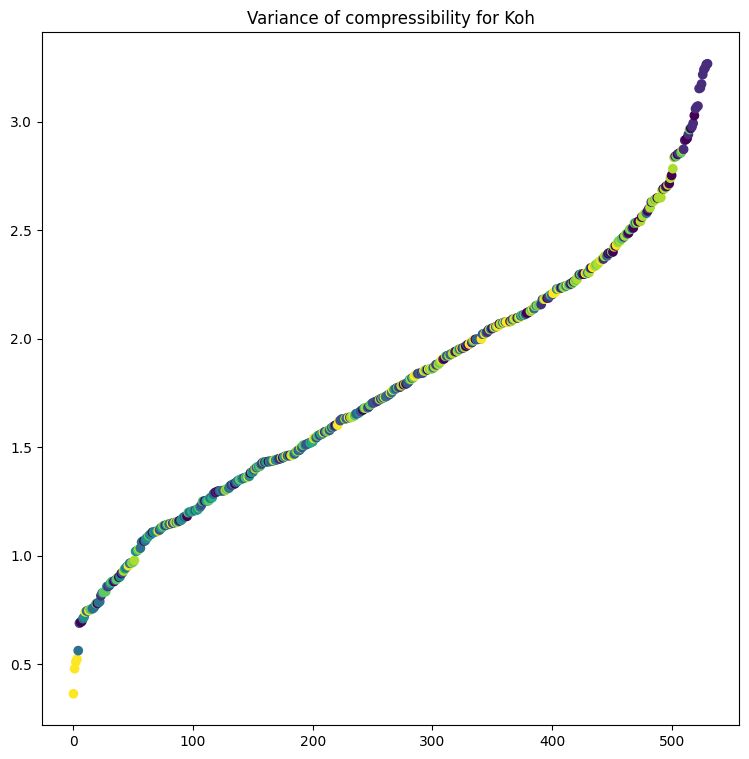

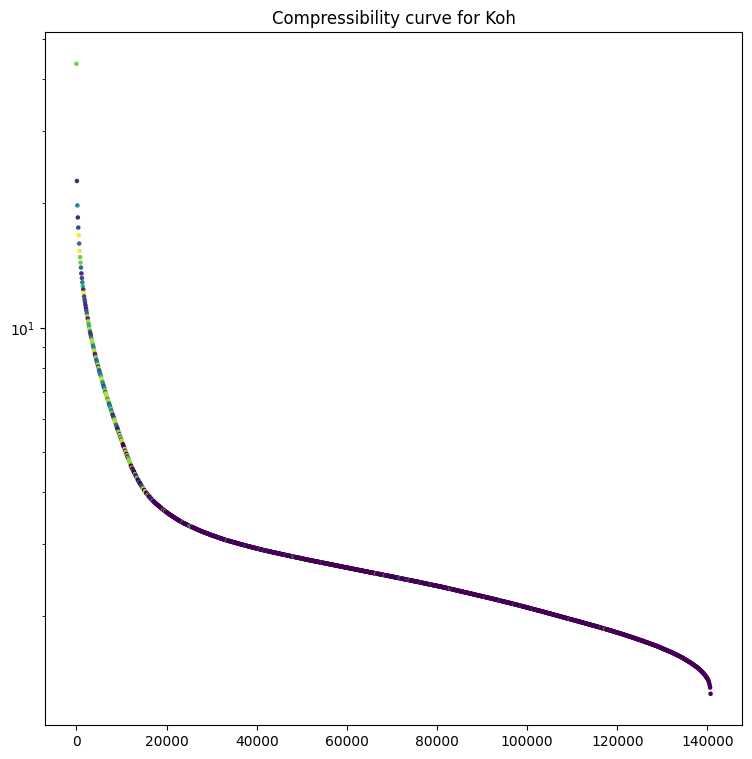

100%|██████████| 25/25 [01:40<00:00,  4.03s/it]


ARI without removal: 0.8052983712631564
NMI without removal: 0.8661362611705073
Avg intercluster compressibility [2.01377177 1.90416891 1.51138838]
Avg intracluster compressibility [10.94613845  8.73087696 10.34747881]


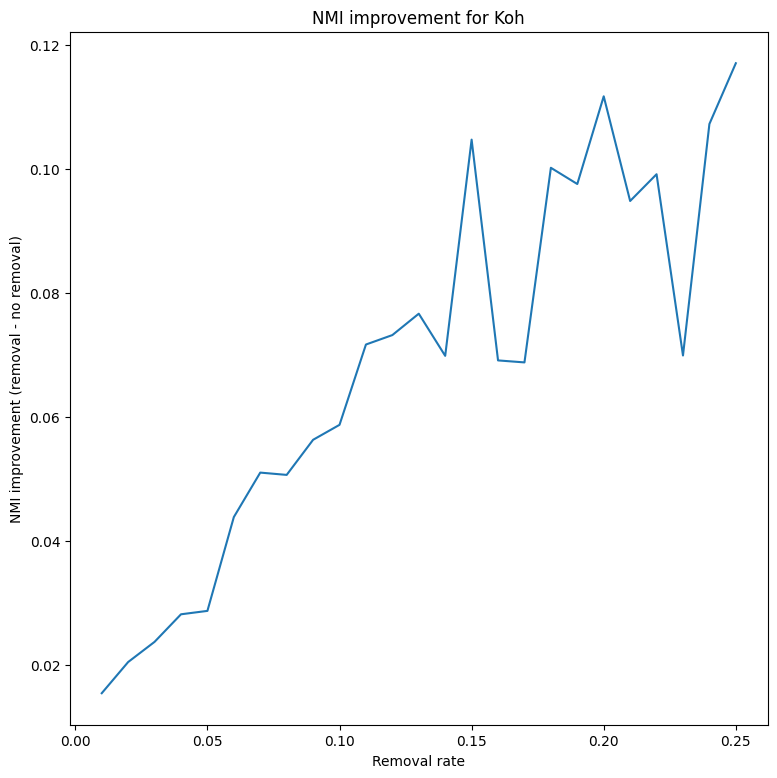

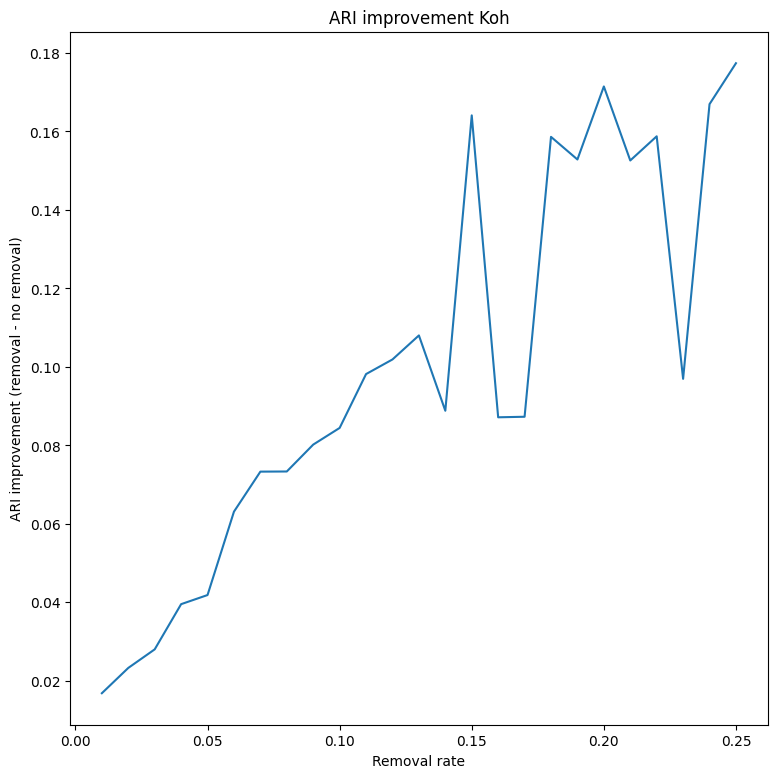

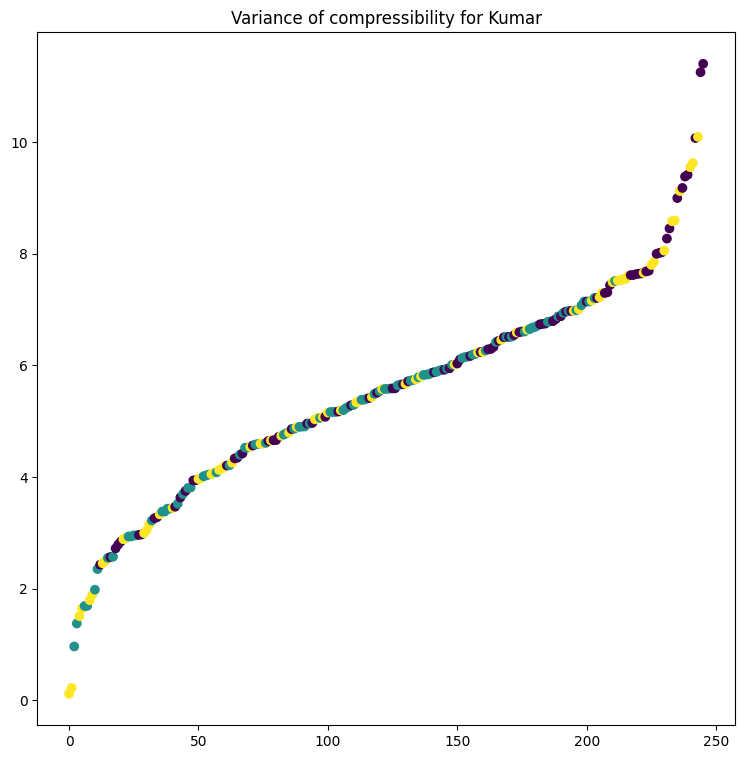

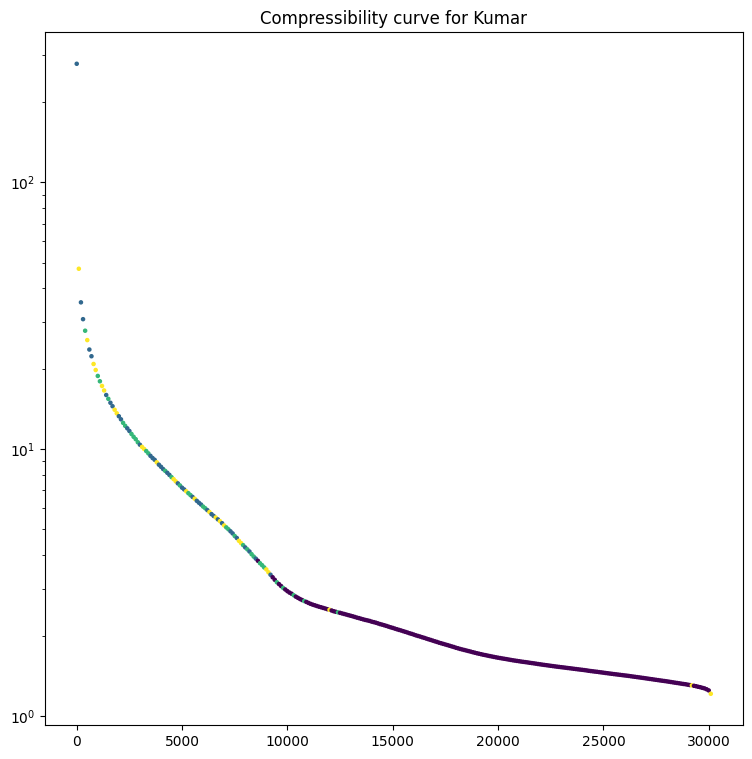

100%|██████████| 25/25 [01:08<00:00,  2.75s/it]


ARI without removal: 0.9507837448896125
NMI without removal: 0.923781516234857
Avg intercluster compressibility [3.39586881 3.30853591 3.07730335 2.80946014]
Avg intracluster compressibility [14.10063809 14.562657   13.538867   13.23659013]


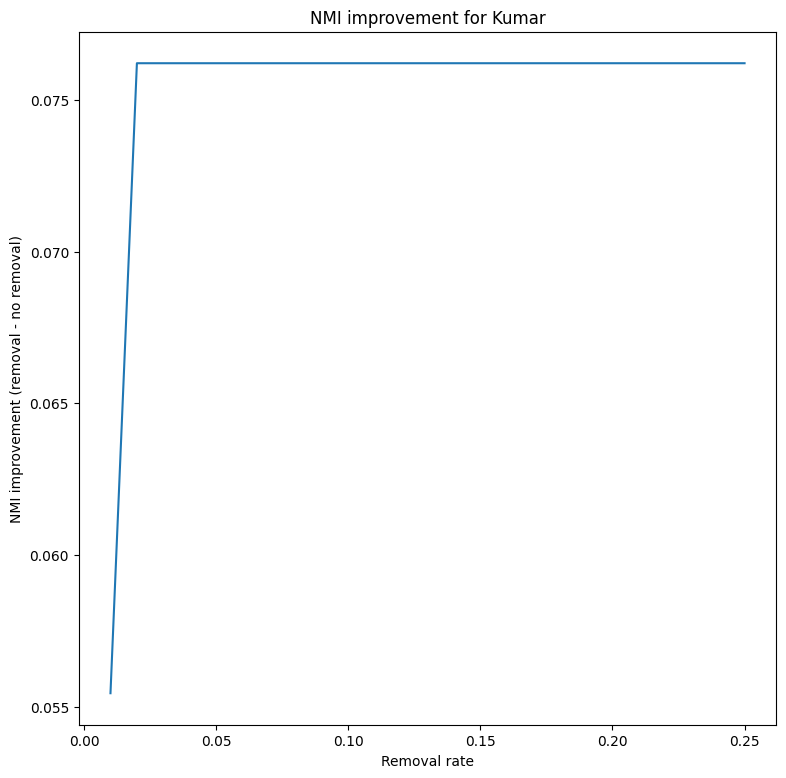

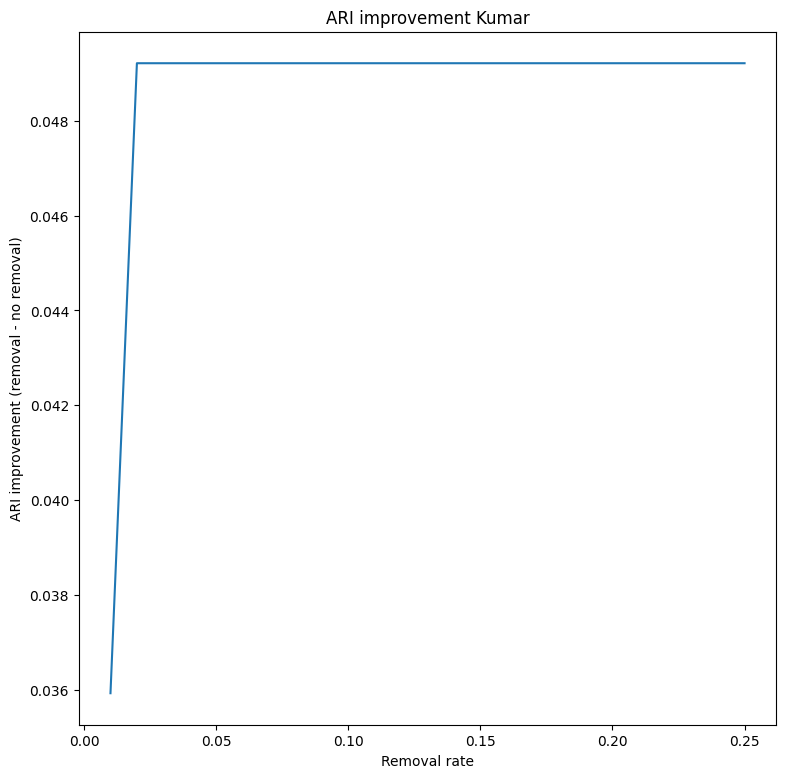

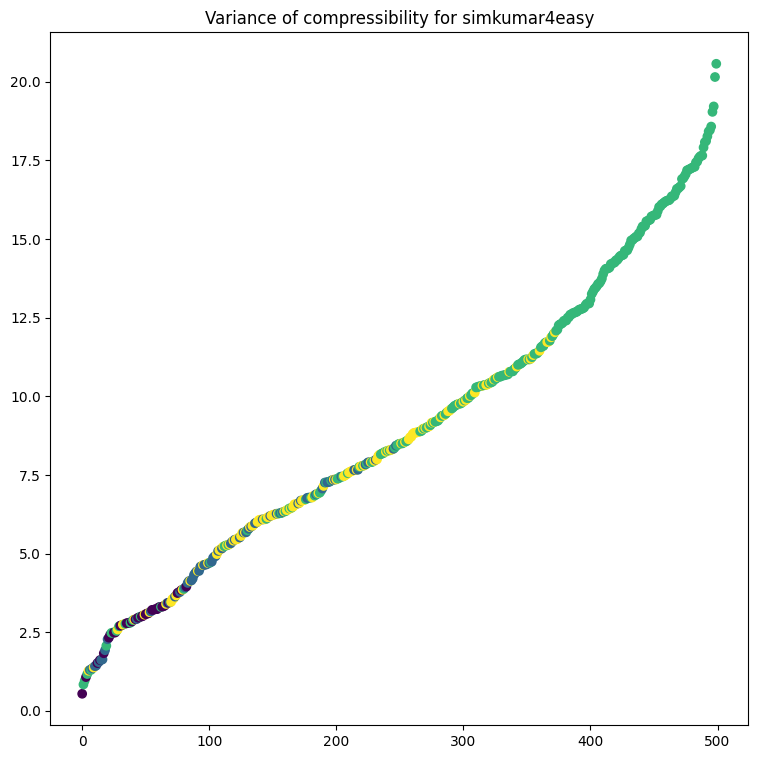

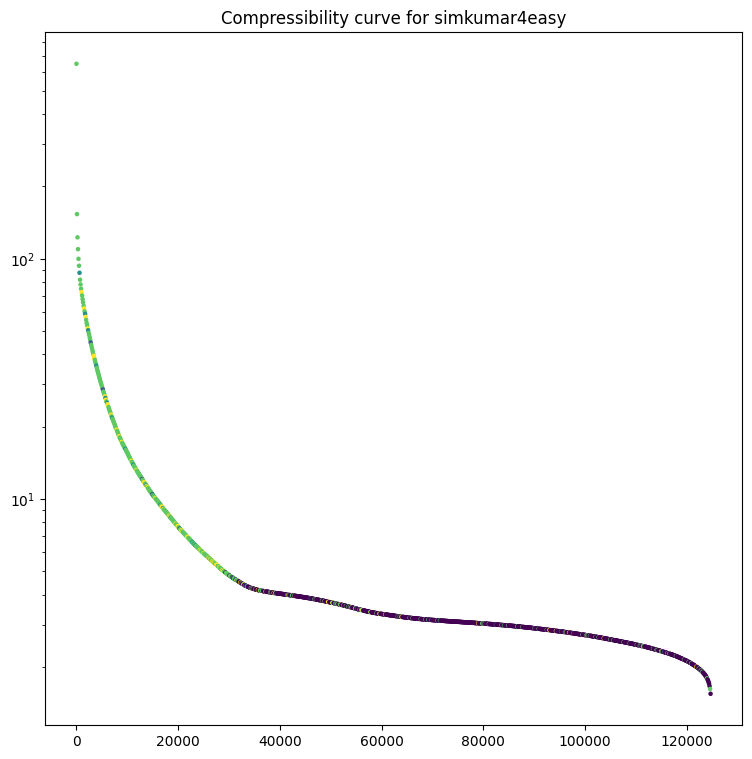

100%|██████████| 25/25 [01:15<00:00,  3.00s/it]


ARI without removal: 0.6230822659273262
NMI without removal: 0.7387088558932995
Avg intercluster compressibility [4.92761441 4.53640422 4.66340437 4.3331462 ]
Avg intracluster compressibility [12.45143797 14.67148155 12.18912956 11.80848025]


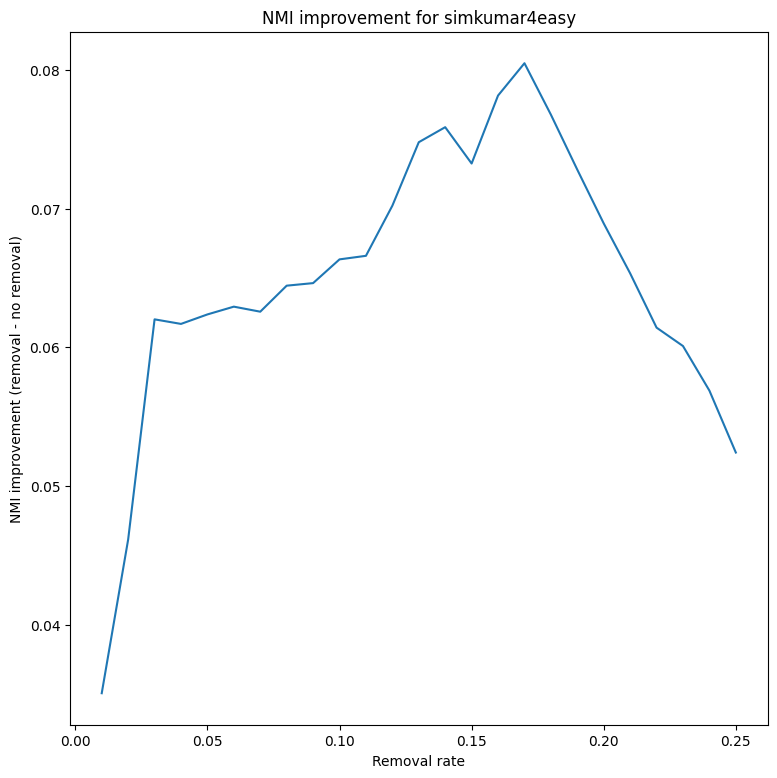

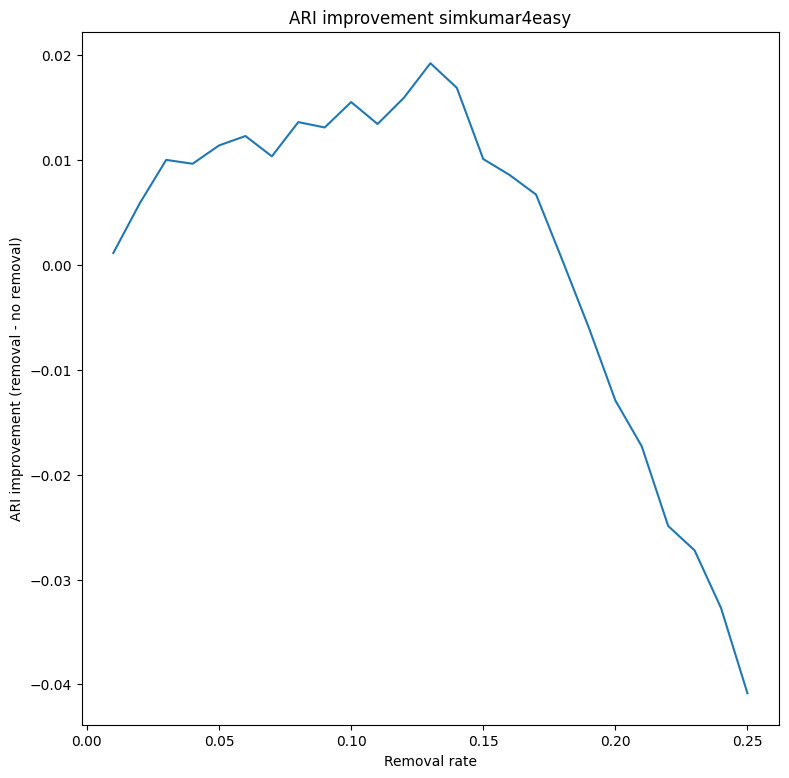

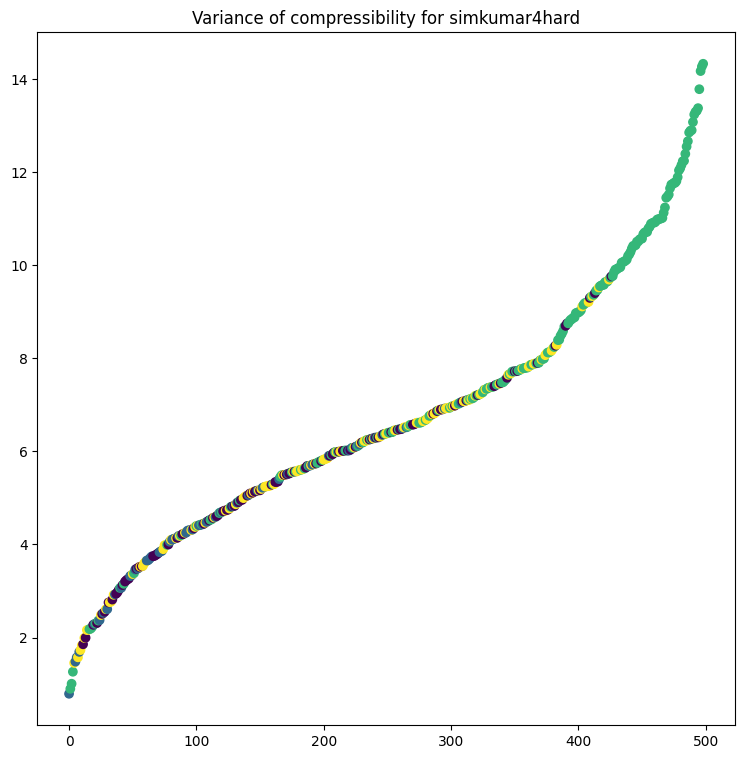

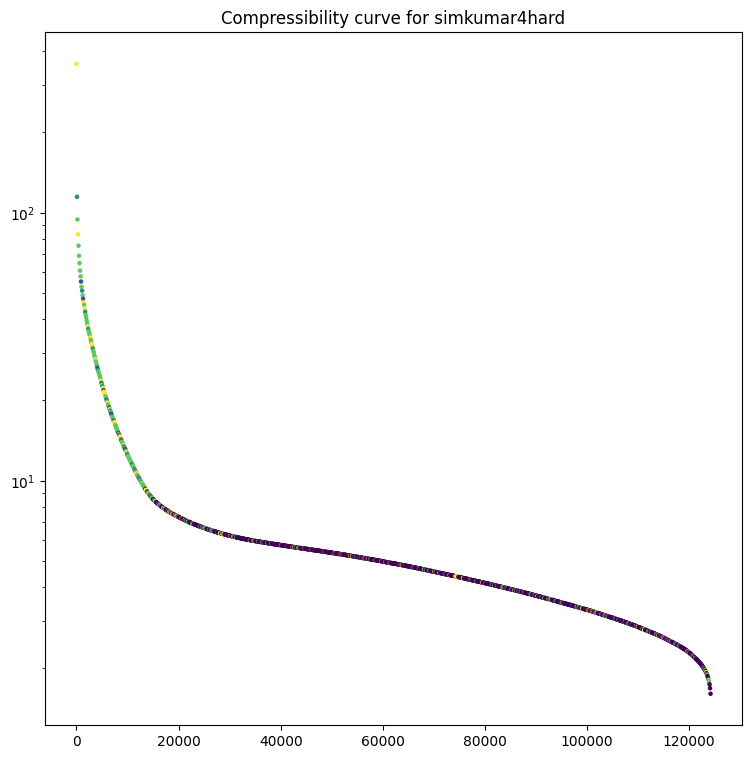

100%|██████████| 25/25 [01:14<00:00,  2.99s/it]


ARI without removal: 0.16482763251632726
NMI without removal: 0.23728892432507084
Avg intercluster compressibility [4.29942027 4.59635387 4.25426557 4.35586506 4.26950275 3.92270792
 3.91938768 3.62179474]
Avg intracluster compressibility [7.84748837 8.9599407  7.66063822 7.72795581 8.1608332  8.1978975
 7.66943222 9.61500116]


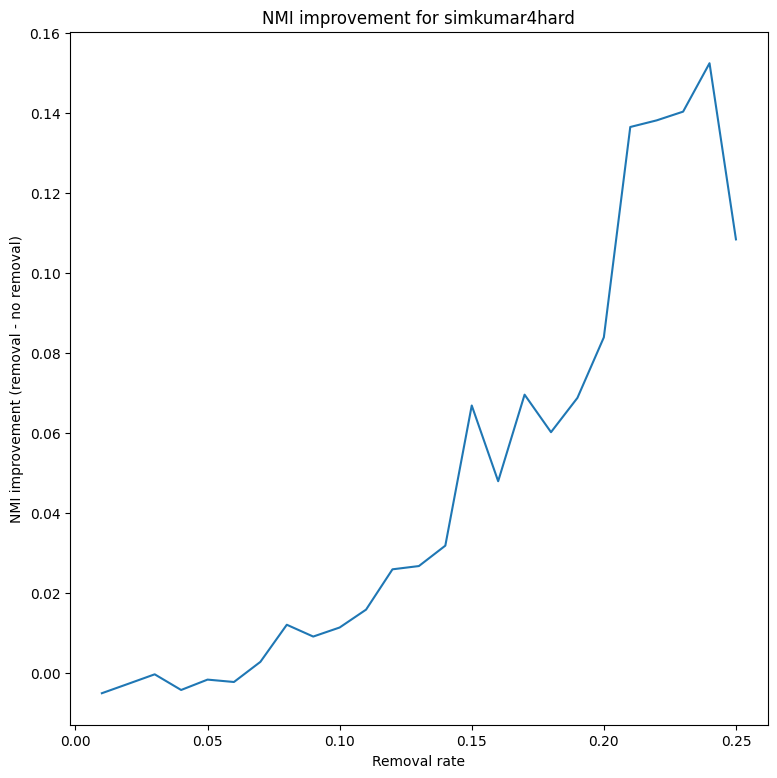

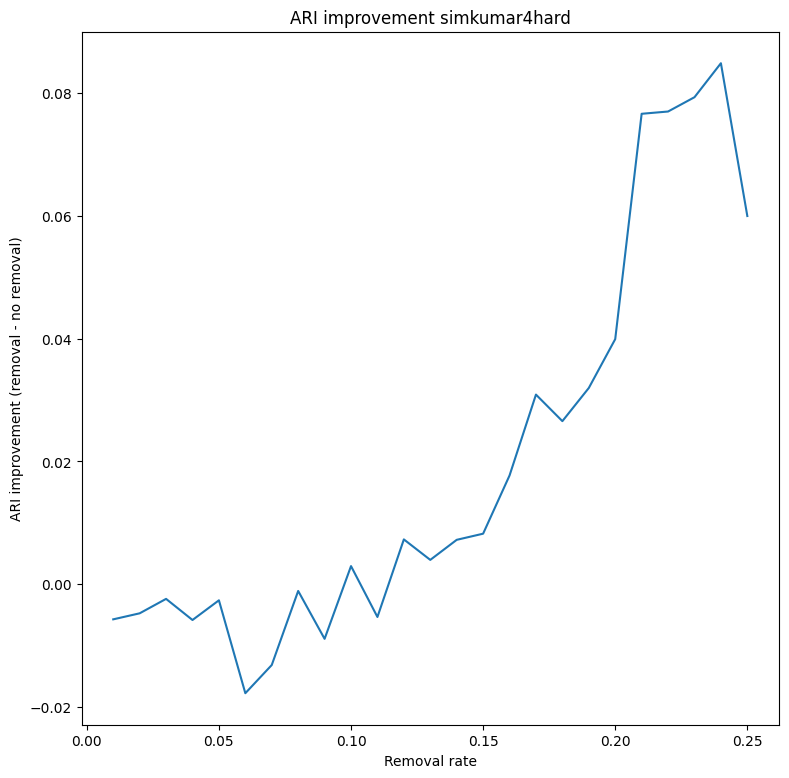

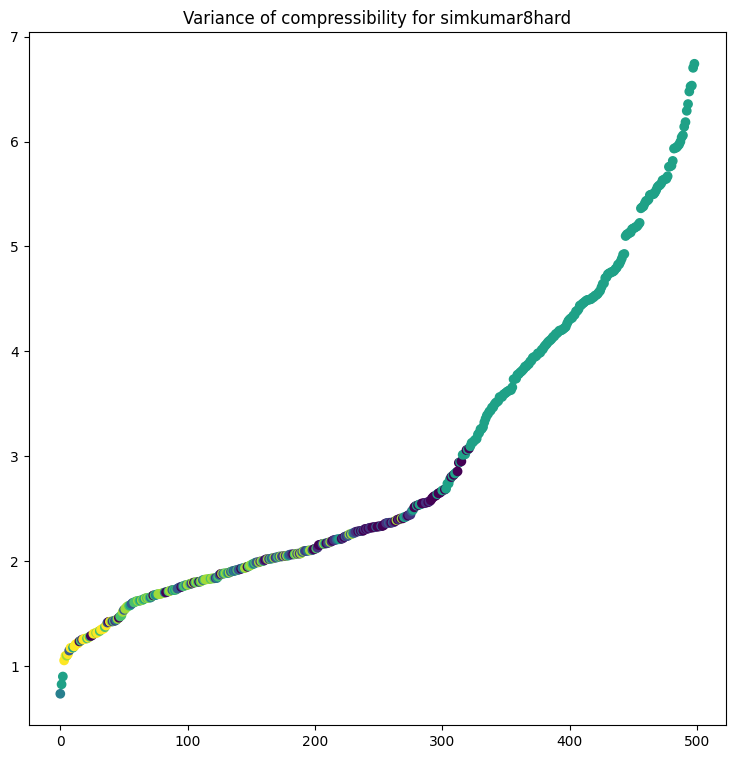

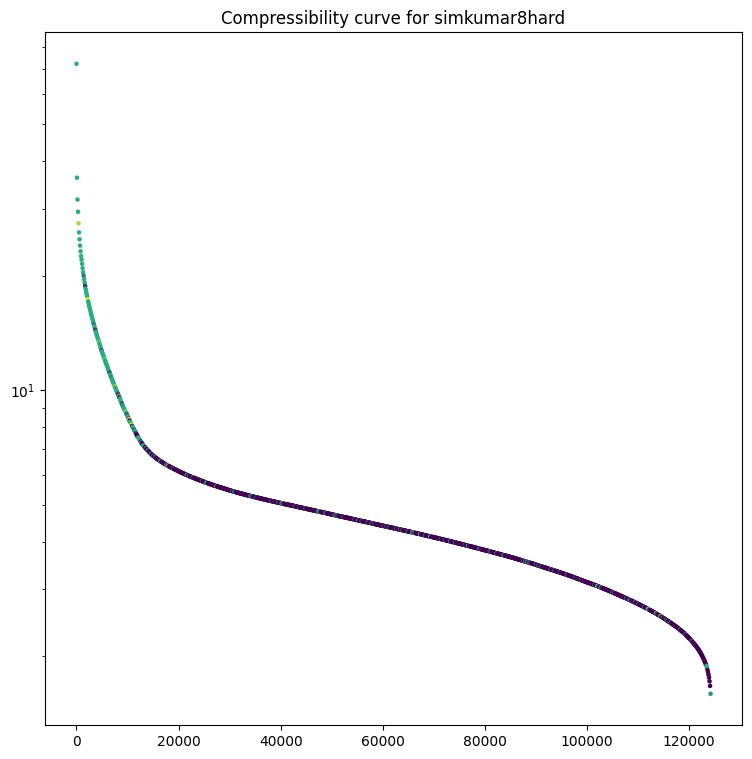

100%|██████████| 25/25 [01:31<00:00,  3.66s/it]


ARI without removal: 0.27816037262861004
NMI without removal: 0.44982201331116023
Avg intercluster compressibility [3.60364781 4.82261131 4.69148433]
Avg intracluster compressibility [5.91345756 6.23246818 6.16450956]


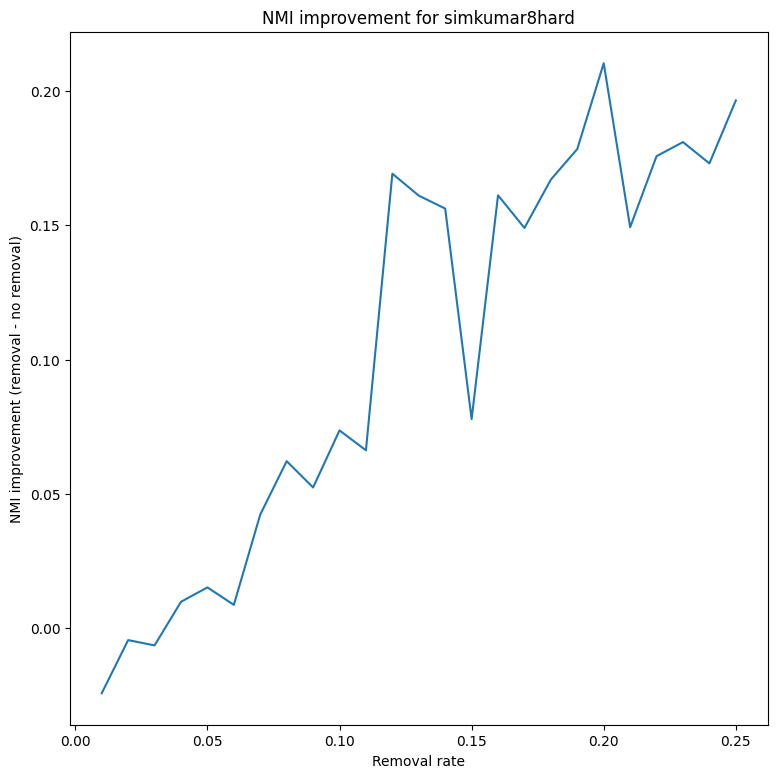

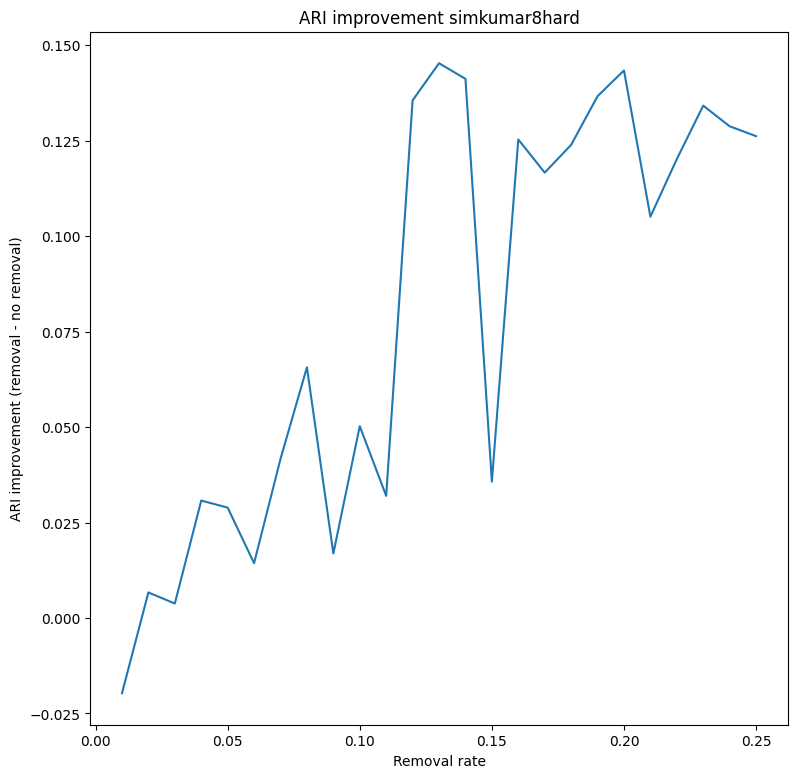

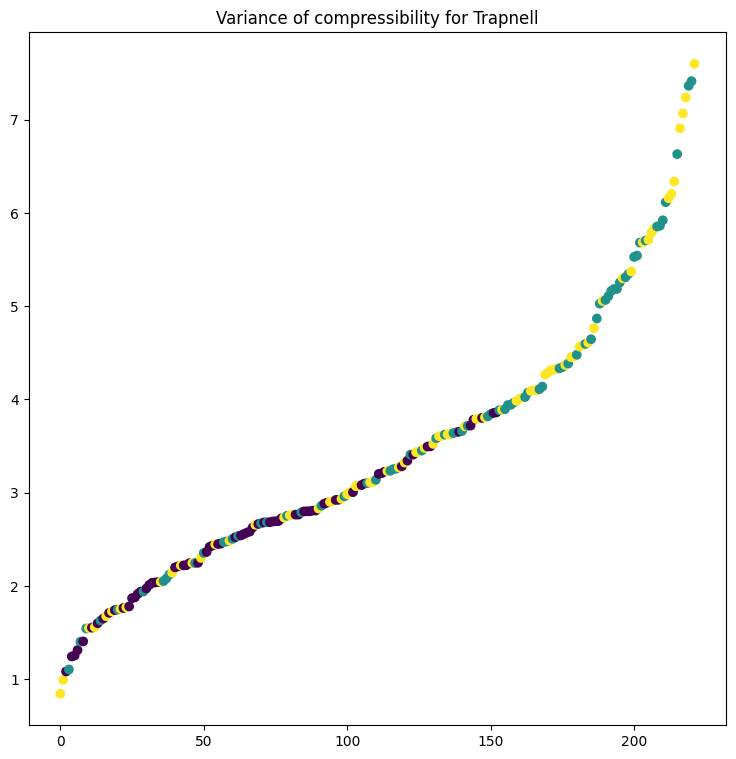

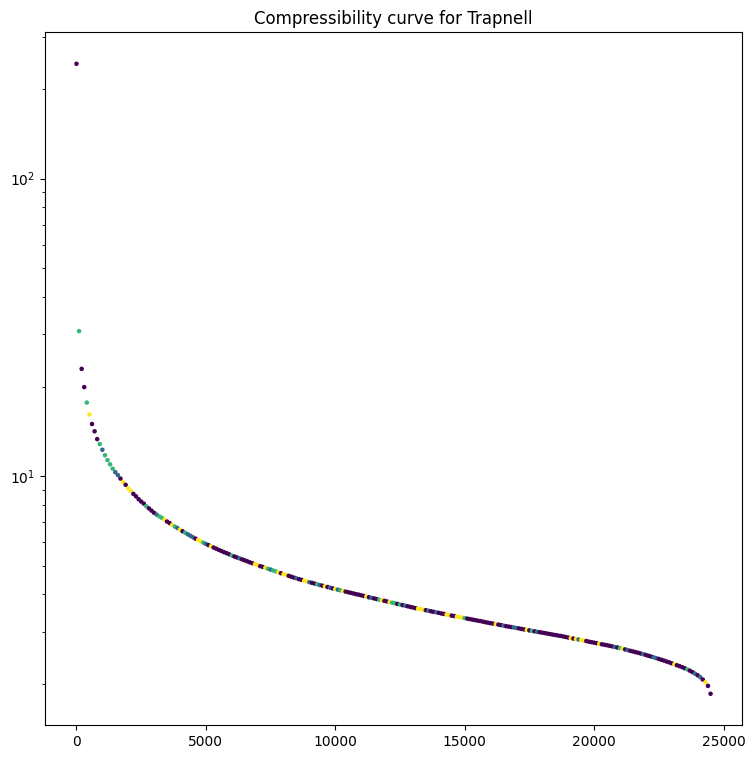

100%|██████████| 25/25 [01:08<00:00,  2.73s/it]


ARI without removal: 0.26736111186426015
NMI without removal: 0.2860664593741712
Avg intercluster compressibility [2.01971456 1.69405043 2.25248836 2.32123145]
Avg intracluster compressibility [5.35631824 5.28801417 6.78049987 5.27209963]


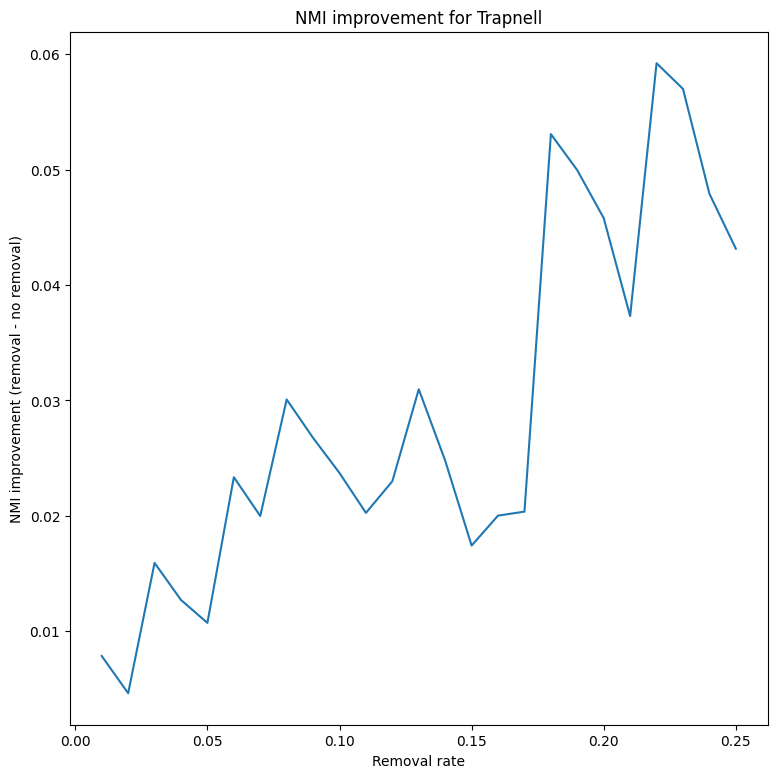

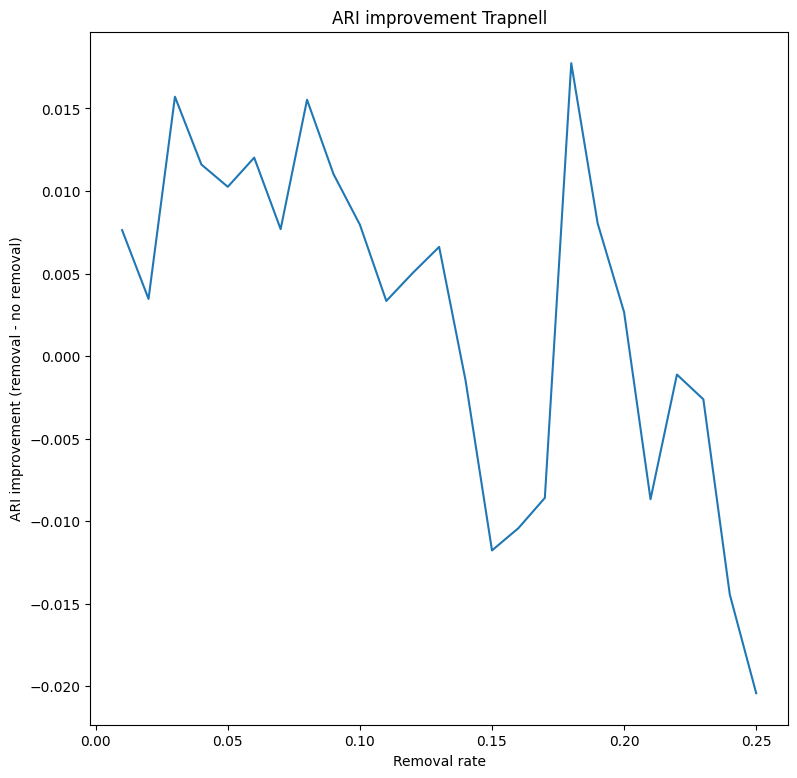

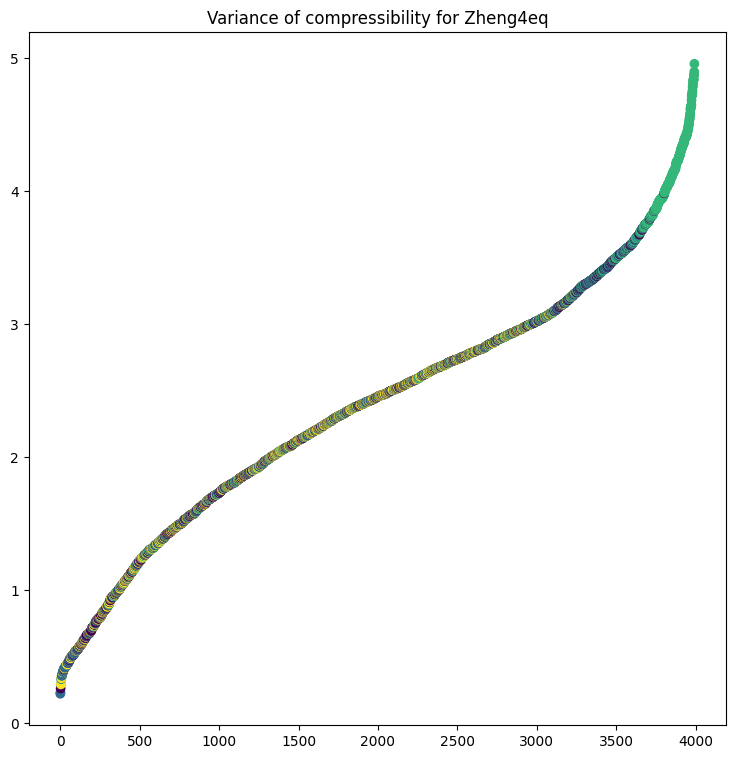

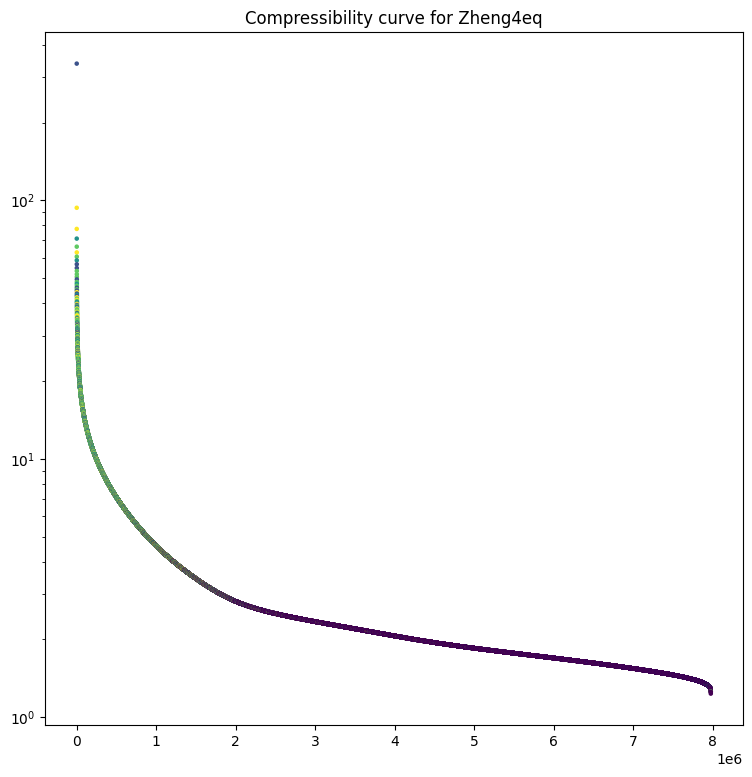

100%|██████████| 25/25 [04:15<00:00, 10.22s/it]


ARI without removal: 0.6287255246783586
NMI without removal: 0.7073847358844679
Avg intercluster compressibility [1.93045148 1.70818449 2.40837    2.02956189]
Avg intracluster compressibility [5.05593631 5.28618187 6.44786619 4.7832041 ]


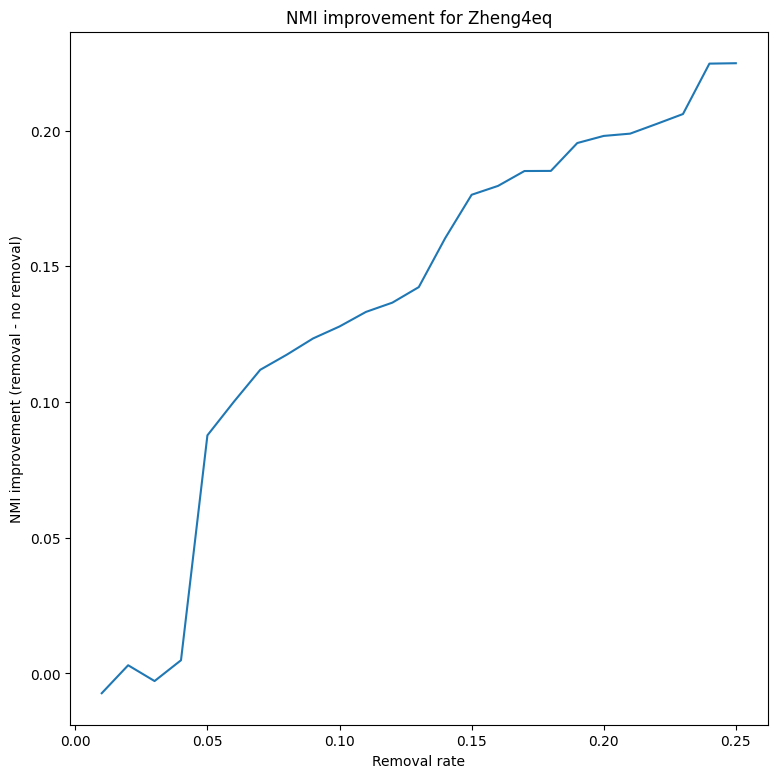

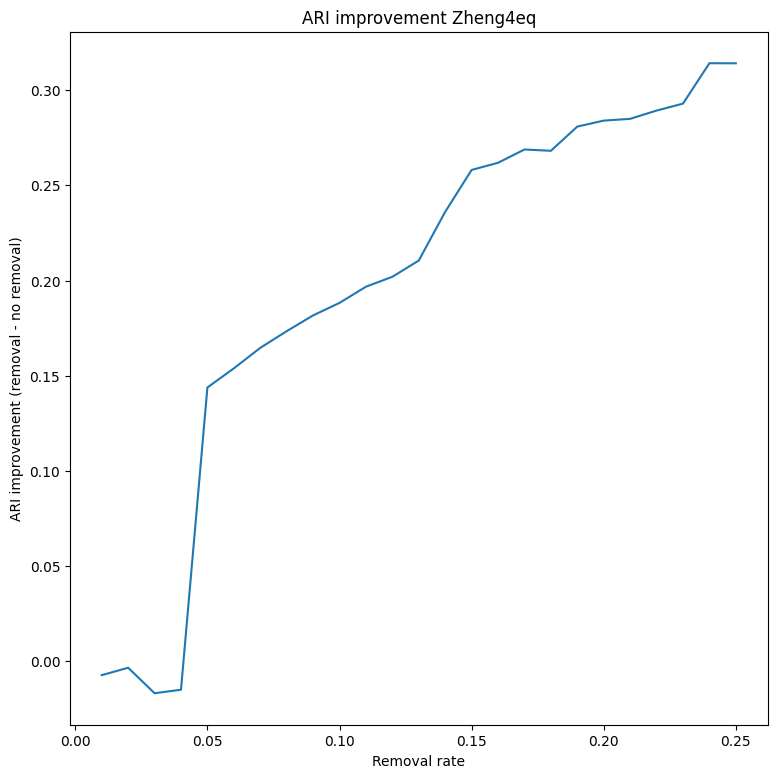

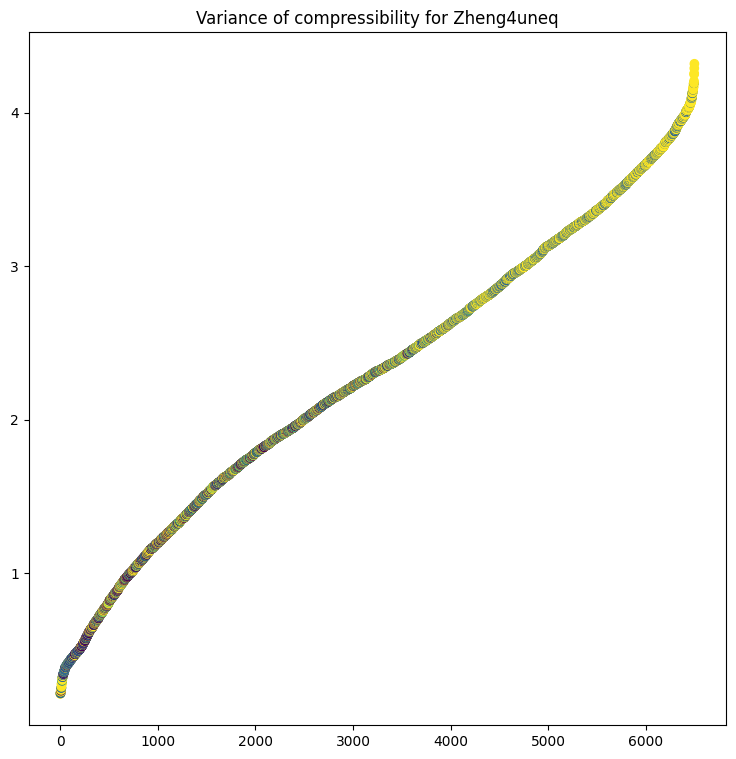

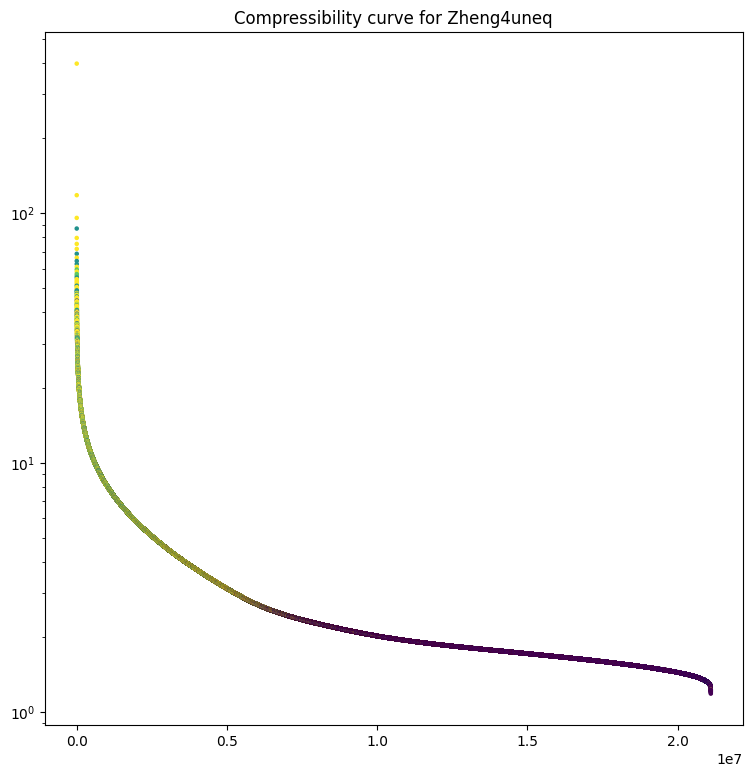

100%|██████████| 25/25 [06:56<00:00, 16.65s/it]


ARI without removal: 0.7380527823082216
NMI without removal: 0.7198190969572521
Avg intercluster compressibility [1.96021739 2.78760546 1.64417967 1.92255693 2.50619489 2.53015936
 2.66873355 2.61445438]
Avg intracluster compressibility [3.96475833 4.22662105 4.13530009 4.725289   3.99631929 5.15276942
 4.62019274 3.92472533]


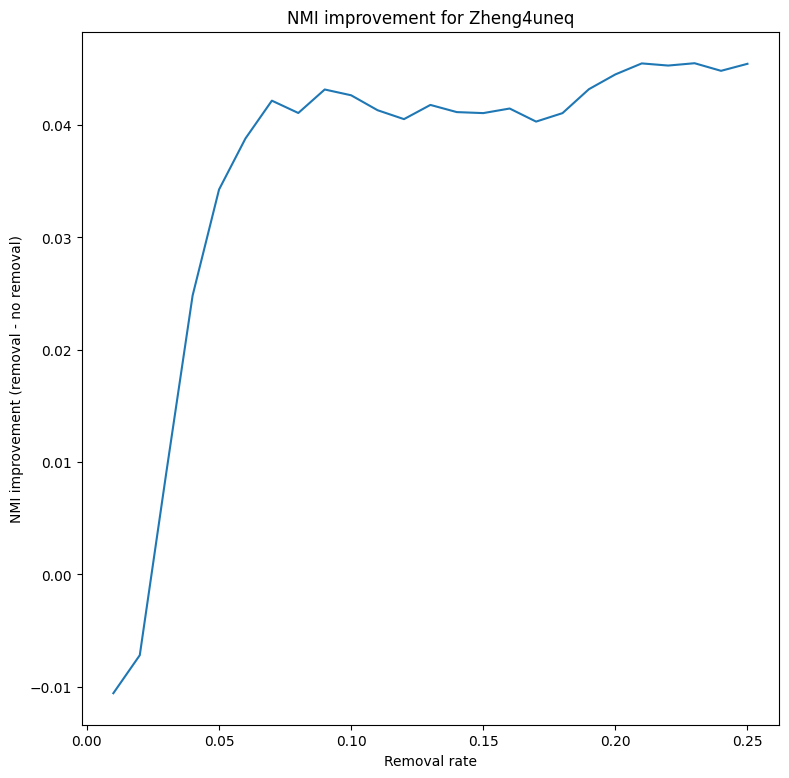

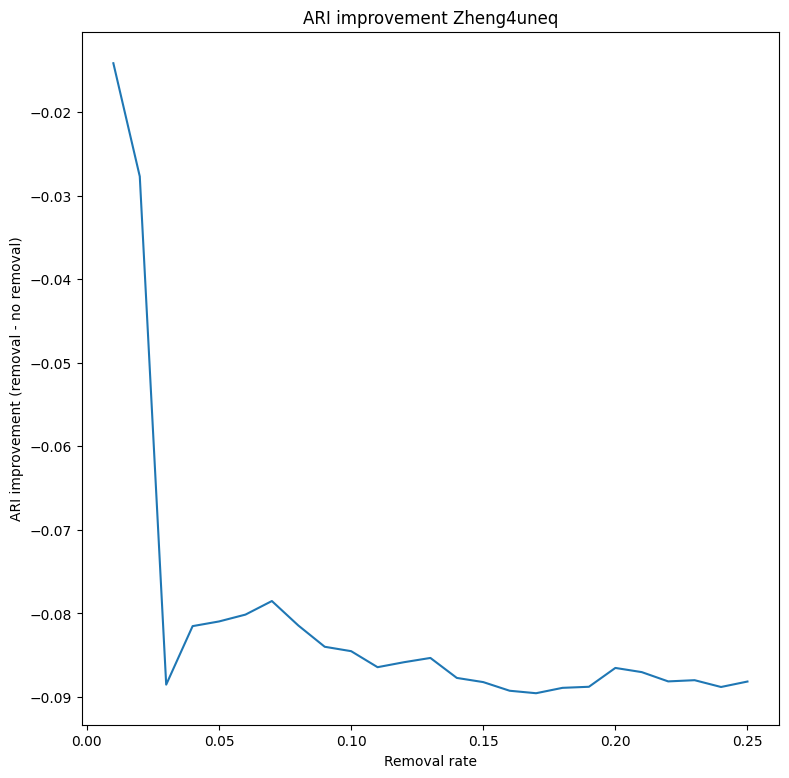

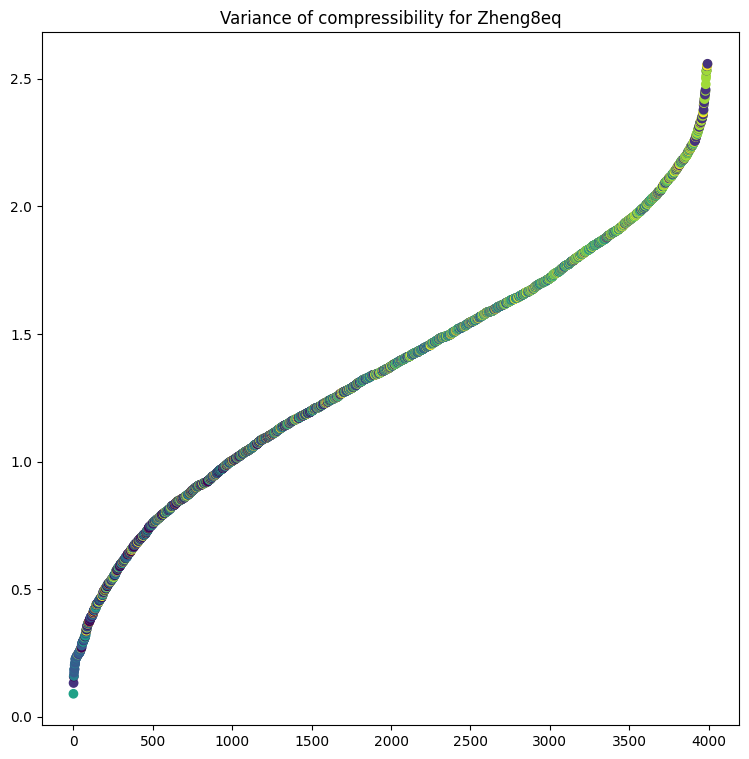

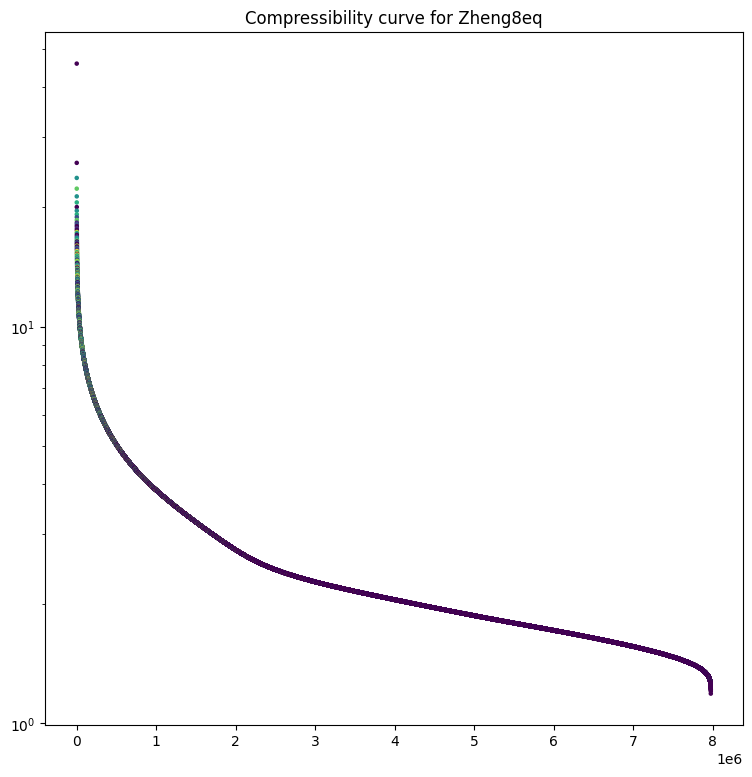

100%|██████████| 25/25 [04:32<00:00, 10.91s/it]

ARI without removal: 0.3861974834156617
NMI without removal: 0.5530214829797364


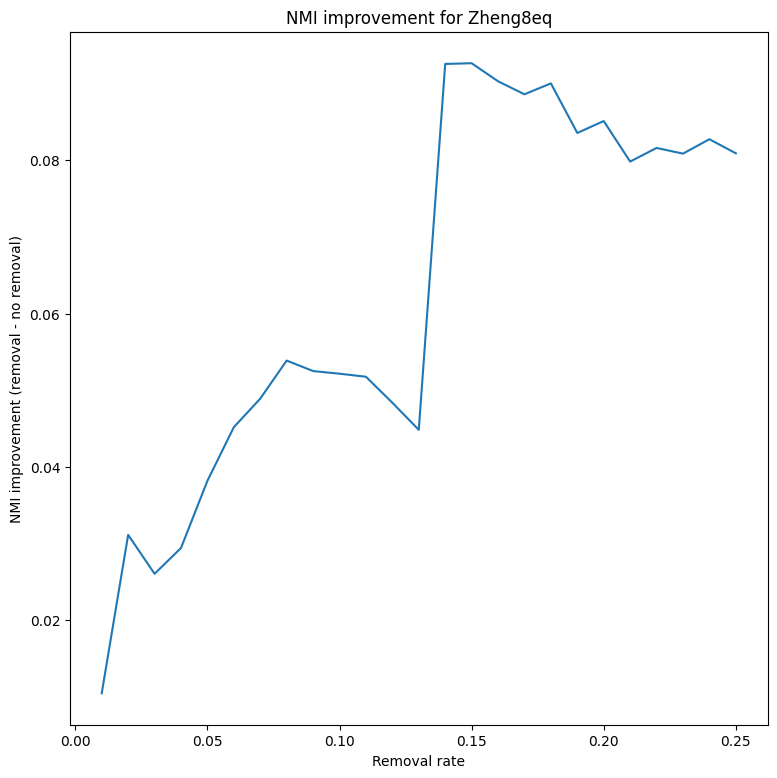

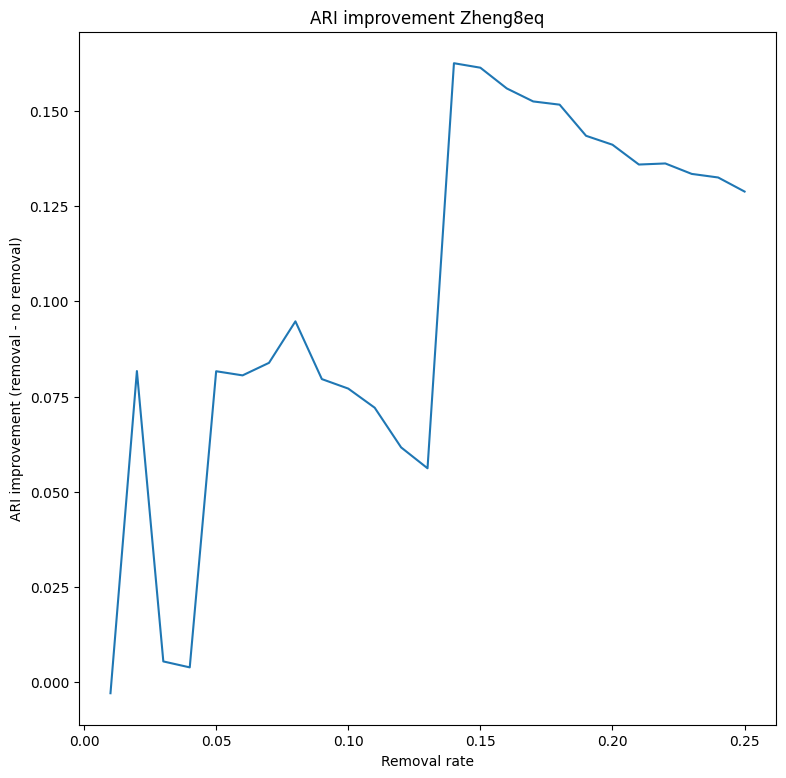

In [10]:
#EXP1
for fix_ch in range(9):
    data, cs, labels = initiate(fix_ch=fix_ch)
    dimension=len(cs)
    C = np.load(dspath[fix_ch][:-5]+'_C_cs.npy')
    process(data,cs,labels,dimension,fix_ch, C)

Avg intercluster compressibility [2.13020215 2.18821844 2.20546764 2.22515674 2.240513   2.24897005
 2.01772537 2.34249446 1.8436378 ]
Avg intracluster compressibility [4.8155104  4.15475407 3.01274893 4.08520576 4.43374062 4.6665418
 3.2128654  5.03865012 4.08724325]


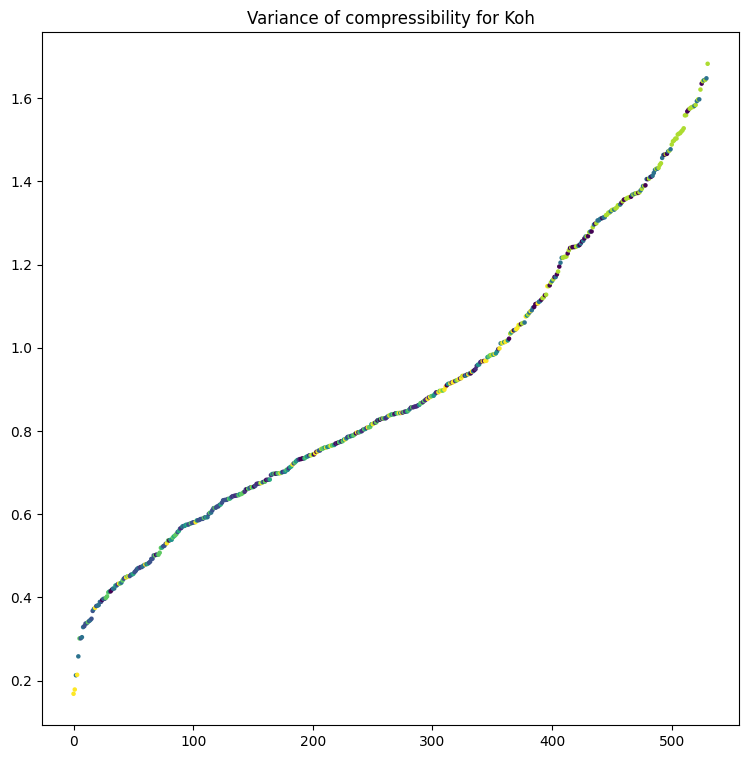

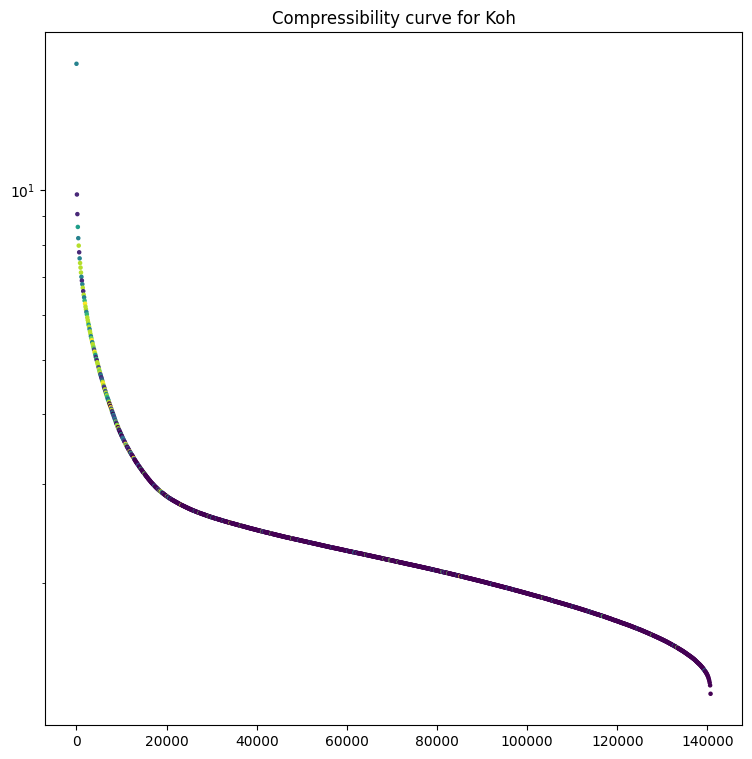

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
#EXP2
dimension=25
for fix_ch in range(9):
    data, cs, labels = initiate(fix_ch=fix_ch)
    C = np.load(dspath[fix_ch][:-5]+'_C_25.npy')
    process(data,cs,labels,dimension,fix_ch, C)